<a href="https://colab.research.google.com/github/pouyarahmti/Pytorch-Deep-Learning-Bootcamp/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow


In [148]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt


# Check PyTorch version
torch.__version__

'2.2.1+cu121'

## Data (preparing and loading)

data can be almost anything .... in Machine Learning.

* Excel Spreadsheet
* Images of any kind
* Videos
* Text
* Audio

Machine learning is a game of two parts:
1. Get data into the numerical format
2. Build a model to learn patterns in that numerical data


We'll use linear regression formula to make a straight line with *known* **parameters**.

In [149]:
# Create known parameters

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [150]:
len(X), len(y)

(50, 50)

In [151]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Splitting data into training and test sets (one of most important machine learning workflow)

In [152]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [153]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [154]:
# Plot Predictions

def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):

  """ Plots training data, test data and compares predictions. """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


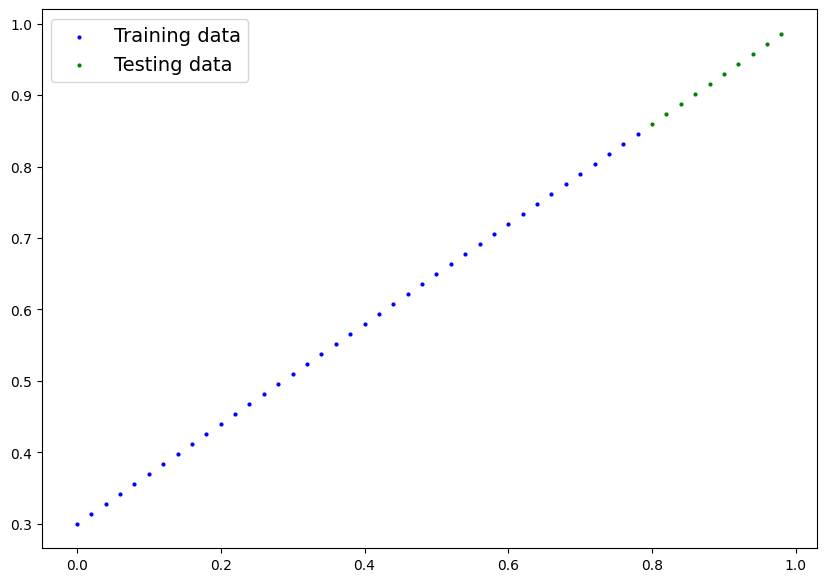

In [155]:
plot_predictions()

## 2. Build Model

What our model does:
* Start with random values (weights and biases)
* Look at the training data and adjust the weights and biases to minimize the loss and get closer to the ideal values for weights and biases

How does it do that?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [156]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula


### PyTorch model building essentials

* torch.nn - contains all of PyTorch's building blocks for neural networks
* torch.nn.Parameter - What parameters should our model try and learn
* torch.nn.Modules - the base class for all neural network modules, if you subclass nn.Module, you should override **forward** method
* torch.nn.functional - contains all of PyTorch's building blocks for neural networks
* torch.optim - contains all of PyTorch's optimizers, they will help with gradient descent
* def forward(self, x) - defines the computation performed at every call

### Checking the contents of our model

we can check the contents of our model by running the following code:

```model.parameters() ```

In [157]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

In [158]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [159]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode`


In [160]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something like this, however, torch.inference_mode() is more preferred
# Using torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

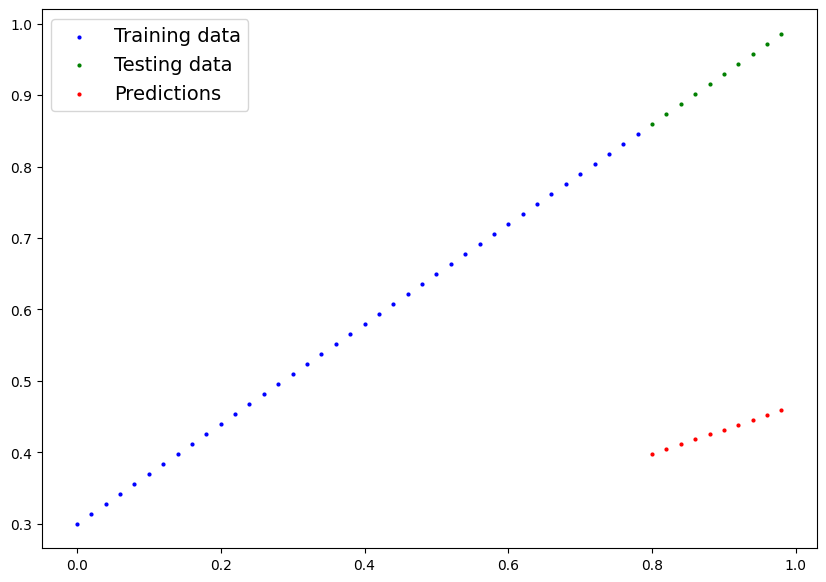

In [161]:
# Plot predictions
plot_predictions(predictions=y_preds)

## 3. Training the model

the whole idea of training a model is for a model to move from some *unknown* parameters (those may be random) to some *known* parameters.
in Other word from poor parameters to good parameters

one way to measure how good or how poor a model is is by looking at the loss function

* Note (1): the loss function is a function that measures how good or how bad a model is

* Note (2): Loss function is also called cost function or criterion

Things we need to train:

* **Loss function**: measures how good or how bad our model is

* **Optimizer**: a way of updating our model parameters with taking into account the loss function and adjust model parameters

and specifically for PyTorch:

* **Training Loop**
* **Testing Loop**

In [162]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01,) # lr = learning rate = possibly the most important hyperparameter you can set


### Build training loop in PyTorch

0. Loop Through Data
1. Forward pass (this involves data moving through out `forward()` method) - also called forward propagation
2. Calculate loss (compare forward pass prediction with actual data)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate gradients of each of the parameters in the network with respect to the loss (**Backpropagation**)
5. Optimizer step - Use the optimizer to update the parameters (**Gradient Descent**)

In [163]:
# An epoch is one loop through the data... (This is a hyperparameter because we've set it ourselves)
epoches = 200

# Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epoches):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # model_0.eval() # turns off gradient tracking

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them at each iteration

  ### Testing
  model_0.eval() # turn off different settings in the model not needed for evaluation/testing (dropout/batch norm)
  with torch.inference_mode(): # turn off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [164]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [165]:
weight, bias

(0.7, 0.3)

In [166]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [167]:
torch.tensor(loss_values), loss_values

(tensor([0.3129, 0.1977, 0.0891, 0.0531, 0.0454, 0.0417, 0.0382, 0.0348, 0.0313,
         0.0279, 0.0245, 0.0210, 0.0176, 0.0142, 0.0107, 0.0073, 0.0039, 0.0089,
         0.0089, 0.0089]),
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackward0>),
  tensor(0.0073, grad_fn=<MeanBackward0>),
  tensor(0.0039, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackwar

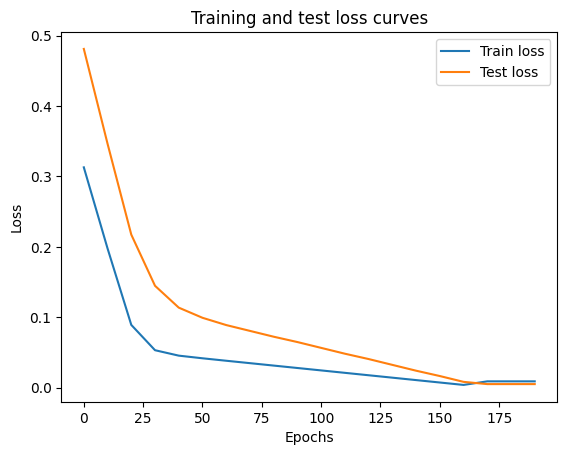

In [168]:
# Plot the loss curves
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [169]:
plot_predictions

<function __main__.plot_predictions(train_data=tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]]), train_labels=tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260],
        [0.4400],
        [0.4540],
        [0.4680],
        [0.4820],
        [0.4960],
        [0.5100],
        [0.5240],
        [0.5380],
        [0.5520],
        [0.5660],
        [0.5800],
        [0.5940],
        [0.6080],
        [0.6220],
        [0.6360],
        [0.6500],
        [0.6640],
        [0.6780],
        [0.6920],
        [0.7060],
        [0.7200],
        [0.7340],
        [0.7480],
        [0.7620],
        [0.7760],
        [0.7900],
        [0.8040],
        [0.8180],
        [0.8320],
        [0.8460]]), test_data=tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]]), test_labels=tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]]), predictions=None)>

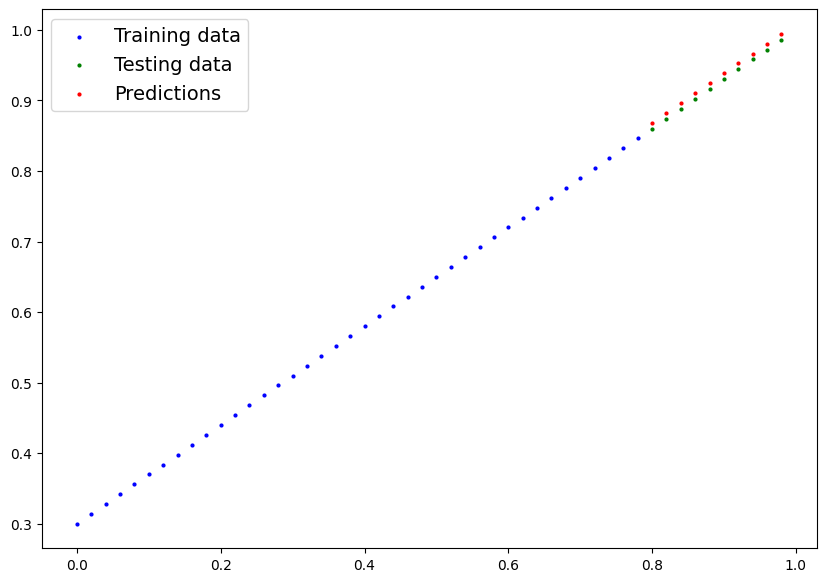

In [170]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

there are three main methods you should know for saving and loading PyTorch models.

1. `torch.save()` - allows you to save a model in PyTorch in Python Pickle format
2. `torch.load()` - allows you to load a PyTorch model
3. `torch.nn.Module.load_state_dict()` - allows you to load a PyTorch model saved state dictionary


In [171]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [172]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Load a PyTorch model

since we saved our model's `state_dict()`, we can load it to a new instance of the model:


In [173]:
# Load a PyTorch model

loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [174]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

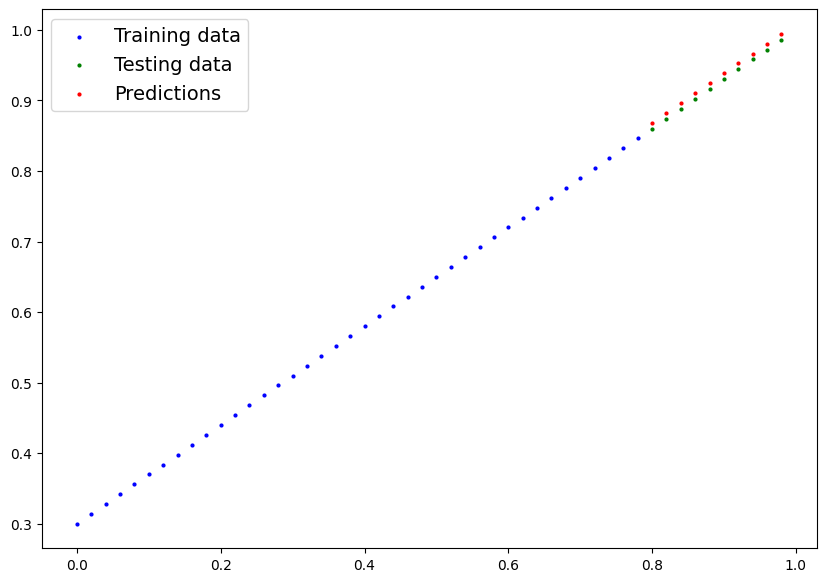

In [175]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)

In [176]:
loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

### 6.1 Prepare data

In [177]:
import torch
from torch import nn
import matplotlib.pyplot as plt


torch.__version__

'2.2.1+cu121'

In [178]:
# Device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [179]:
# Prepare data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# Create a range of numbers between start and end
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


In [180]:
len(X), len(y)

(100, 100)

In [181]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

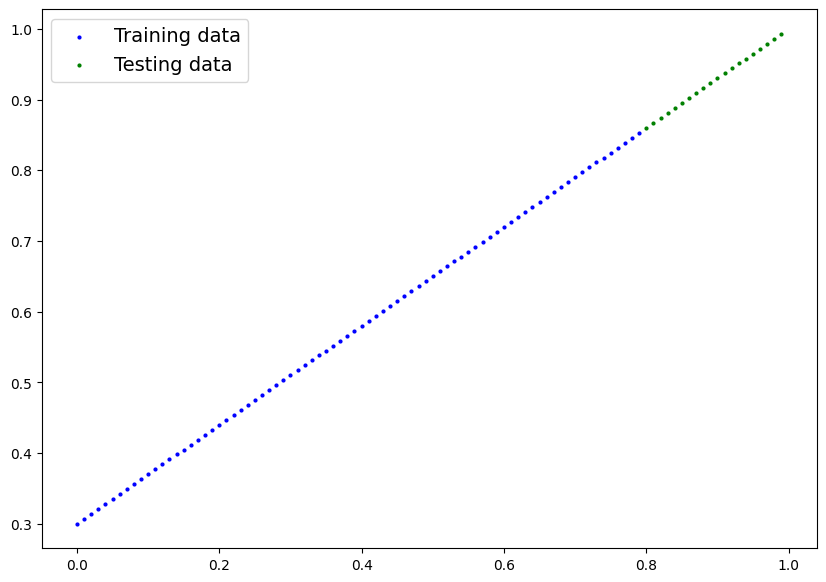

In [182]:
plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test)

### 6.2 Create a PyTorch Linear Regression Model

In [183]:
## Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


# set manual seed
torch.manual_seed(42)

# create an instance of the model
model_1 = LinearRegressionModelV2()


In [184]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [185]:
model_1.to(device)
print(next(model_1.parameters()).device)

cuda:0


### 6.3 Training with PyTorch

for training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop


In [186]:
# set up loss function
loss_fn = nn.MSELoss()

# set up an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [187]:
# Training loop

epoches = 200

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epoches):

  # Set model to train mode
  model_1.train()

  # Forward Pass
  y_pred = model_1(X_train)

  # Loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.3088030517101288 | Test loss: 0.3235659897327423
Epoch: 10 | Loss: 0.17431046068668365 | Test loss: 0.1458924561738968
Epoch: 20 | Loss: 0.08386874198913574 | Test loss: 0.04354185238480568
Epoch: 30 | Loss: 0.033546995371580124 | Test loss: 0.0039499844424426556
Epoch: 40 | Loss: 0.012088689021766186 | Test loss: 0.002530790166929364
Epoch: 50 | Loss: 0.0059481109492480755 | Test loss: 0.013782821595668793
Epoch: 60 | Loss: 0.005059956572949886 | Test loss: 0.022068897262215614
Epoch: 70 | Loss: 0.004869445692747831 | Test loss: 0.02360510639846325
Epoch: 80 | Loss: 0.004451738204807043 | Test loss: 0.020947514101862907
Epoch: 90 | Loss: 0.003985004033893347 | Test loss: 0.01729573681950569
Epoch: 100 | Loss: 0.003593171713873744 | Test loss: 0.014290380291640759
Epoch: 110 | Loss: 0.0032545810099691153 | Test loss: 0.012241114862263203
Epoch: 120 | Loss: 0.0029371450655162334 | Test loss: 0.010883580893278122
Epoch: 130 | Loss: 0.0026358880568295717 | Test loss: 0.

In [188]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5593]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3614], device='cuda:0'))])

In [189]:
weight, bias

(0.7, 0.3)

In [190]:
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8089],
        [0.8145],
        [0.8201],
        [0.8257],
        [0.8313],
        [0.8369],
        [0.8424],
        [0.8480],
        [0.8536],
        [0.8592],
        [0.8648],
        [0.8704],
        [0.8760],
        [0.8816],
        [0.8872],
        [0.8928],
        [0.8984],
        [0.9040],
        [0.9096],
        [0.9152]], device='cuda:0')

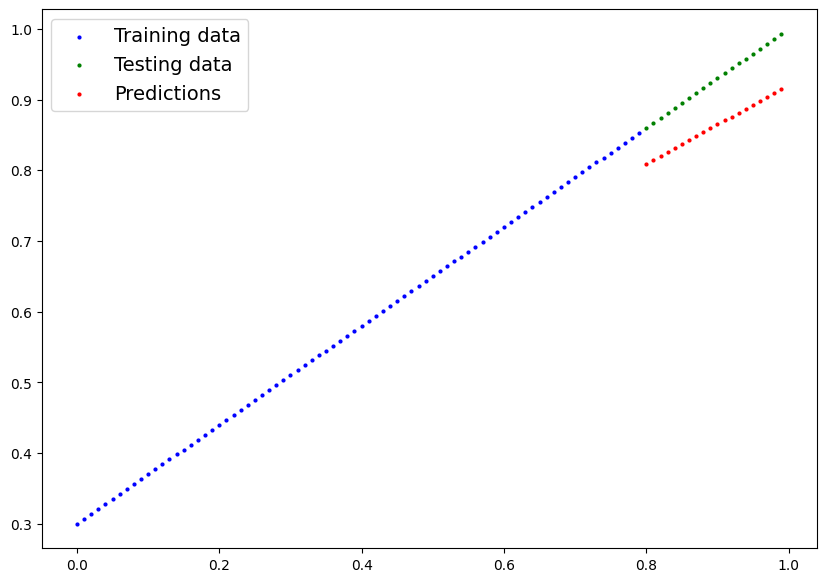

In [191]:
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()
y_preds = y_preds.cpu()

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

### 6.4 Save and load a PyTorch model

In [192]:
# Save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_1.state_dict(), MODEL_SAVE_PATH)

In [193]:
# Load the model
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [194]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5593]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3614], device='cuda:0'))])

In [195]:
next(loaded_model_1.parameters())

Parameter containing:
tensor([[0.5593]], device='cuda:0', requires_grad=True)

In [198]:
X_test = X_test.to(device)
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds

tensor([[0.8089],
        [0.8145],
        [0.8201],
        [0.8257],
        [0.8313],
        [0.8369],
        [0.8424],
        [0.8480],
        [0.8536],
        [0.8592],
        [0.8648],
        [0.8704],
        [0.8760],
        [0.8816],
        [0.8872],
        [0.8928],
        [0.8984],
        [0.9040],
        [0.9096],
        [0.9152]], device='cuda:0')

In [199]:
y_preds = y_preds.to(device)
loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')